<a href="https://colab.research.google.com/github/reemahmed123/Assigment_1/blob/main/Agumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

import os
import shutil

zip_path = "/content/dataset.zip"
extract_to = "/content/raw_temp"

if os.path.exists(extract_to):
    shutil.rmtree(extract_to)

print(f" Unzipping {zip_path}...")
!unzip -q "{zip_path}" -d "{extract_to}"
print(" Done unzipping.")


 Unzipping /content/dataset.zip...
 Done unzipping.


In [5]:
!wget -q https://raw.githubusercontent.com/Fatimah3844/ML_Project/main/dataset.zip


In [8]:
!ls

dataset.zip  raw_temp  sample_data


In [10]:

import os

file_path = "/content/dataset.zip"

if os.path.exists(file_path):
    size_bytes = os.path.getsize(file_path)
    size_mb = size_bytes / (1024 * 1024)
    print(f" File: {file_path}")
    print(f" Size: {size_mb:.2f} MB")

    if size_mb < 0.1:
        print("\n download field .")
    else:
        print("\n size .")
else:
    print(" file does not exsist")


 File: /content/dataset.zip
 Size: 30.27 MB

 size .


In [11]:

import os
import cv2
import shutil
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- Reproducibility Setup ---
# Setting a seed ensures that the train/test split is the same every time we run the code.
SEED_VAL = 42
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)

# --- Paths & Config ---
raw_source_dir = "/content/raw_temp"
processed_dest_dir = "/content/processed_dataset"
final_img_size = (224, 224)
aug_factor = 2  # Number of augmented copies per image

# Project Classes
target_labels = ["glass", "paper", "cardboard", "plastic", "metal", "trash", "unknown"]

def generate_augmentations(img):
    """
    Apply random transformations: Flip, Rotate, Zoom, Brightness, Blur.
    Used to increase the training set size.
    """
    aug_results = []
    h, w = img.shape[:2]

    for _ in range(aug_factor):
        curr_img = img.copy()
        mod_flag = False

        # 1. Flip
        # Increased probability to 50%
        if random.random() > 0.5:
            code = random.choice([1, 0, -1])
            curr_img = cv2.flip(curr_img, code)
            mod_flag = True

        # 2. Rotation
        # Keep probability at 30% to avoid too many twisted images
        if random.random() > 0.7:  # Adjusted threshold
            angle = random.choice([random.randint(-30, -10), random.randint(10, 30)])
            center = (int(w / 2), int(h / 2))
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            curr_img = cv2.warpAffine(curr_img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
            mod_flag = True

        # 3. Zoom (Crop & Resize)
        # Probability 40%
        if random.random() > 0.6:
            # Zoom range 20% to 40%
            scale = random.uniform(1.2, 1.4)

            new_h, new_w = int(h / scale), int(w / scale)
            start_y = (h - new_h) // 2
            start_x = (w - new_w) // 2

            curr_img = curr_img[start_y:start_y+new_h, start_x:start_x+new_w]
            curr_img = cv2.resize(curr_img, (w, h))
            mod_flag = True

        # 4. Brightness
        # Probability 40%
        if random.random() > 0.6:
            alpha = random.uniform(0.8, 1.2) # Contrast
            beta = random.randint(-30, 30)   # Brightness
            curr_img = cv2.convertScaleAbs(curr_img, alpha=alpha, beta=beta)
            mod_flag = True

        # 5. Blur
        # Lower probability (20%) because too much blur is bad
        if random.random() > 0.8:
            curr_img = cv2.GaussianBlur(curr_img, (5, 5), 0)
            mod_flag = True

        # Ensure at least one change happens
        if not mod_flag:
            curr_img = cv2.flip(curr_img, 1)

        aug_results.append(curr_img)

    return aug_results

# --- Main Execution ---

print("Student 1 Pipeline: Starting Data Preparation...")

# finding folders
found_folders = {}

for root, dirs, files in os.walk(raw_source_dir):
    for d in dirs:
        d_name = d.lower()
        for lbl in target_labels:
            if lbl in d_name and lbl not in found_folders:
                full_p = os.path.join(root, d)
                if len(os.listdir(full_p)) > 0:
                    found_folders[lbl] = full_p

if not found_folders:
    print("Error: No class folders found in zip.")
else:
    # Reset output directory
    if os.path.exists(processed_dest_dir):
        shutil.rmtree(processed_dest_dir)

    print(f"Found {len(found_folders)} classes. Processing...")

    for lbl, src_path in found_folders.items():
        # Naming convention: 0_Glass, 1_Paper, etc.
        idx = target_labels.index(lbl)
        folder_name = f"{idx}_{lbl.capitalize()}"

        # Create directories
        os.makedirs(os.path.join(processed_dest_dir, "train", folder_name), exist_ok=True)
        os.makedirs(os.path.join(processed_dest_dir, "val", folder_name), exist_ok=True)

        # Collect images
        valid_exts = ('.jpg', '.jpeg', '.png')
        files_list = [f for f in os.listdir(src_path) if f.lower().endswith(valid_exts)]

        if not files_list: continue

        # Split (80/20)
        train_files, val_files = train_test_split(files_list, test_size=0.2, random_state=SEED_VAL)

        # 1. Handle Training Data (with Augmentation)
        for f in tqdm(train_files, desc=f"Train: {folder_name}"):
            img = cv2.imread(os.path.join(src_path, f))
            if img is None: continue

            # Resize
            img = cv2.resize(img, final_img_size)

            # Save original
            cv2.imwrite(os.path.join(processed_dest_dir, "train", folder_name, f), img)

            # Save augmented
            try:
                augmented_list = generate_augmentations(img)
                for i, aug_img in enumerate(augmented_list):
                    aug_name = f"aug_{i}_{f}"
                    cv2.imwrite(os.path.join(processed_dest_dir, "train", folder_name, aug_name), aug_img)
            except:
                pass

        # 2. Handle Validation Data (No Augmentation)
        for f in val_files:
            img = cv2.imread(os.path.join(src_path, f))
            if img is None: continue

            img = cv2.resize(img, final_img_size)
            cv2.imwrite(os.path.join(processed_dest_dir, "val", folder_name, f), img)

    # Final Step: Zip
    print("\nCreating final zip file...")
    shutil.make_archive("/content/processed_data_final", 'zip', processed_dest_dir)
    print("Done, Download 'processed_data_final.zip'.")


Student 1 Pipeline: Starting Data Preparation...
Found 6 classes. Processing...


Train: 4_Metal: 100%|██████████| 262/262 [00:00<00:00, 310.79it/s]



Creating final zip file...
Done, Download 'processed_data_final.zip'.


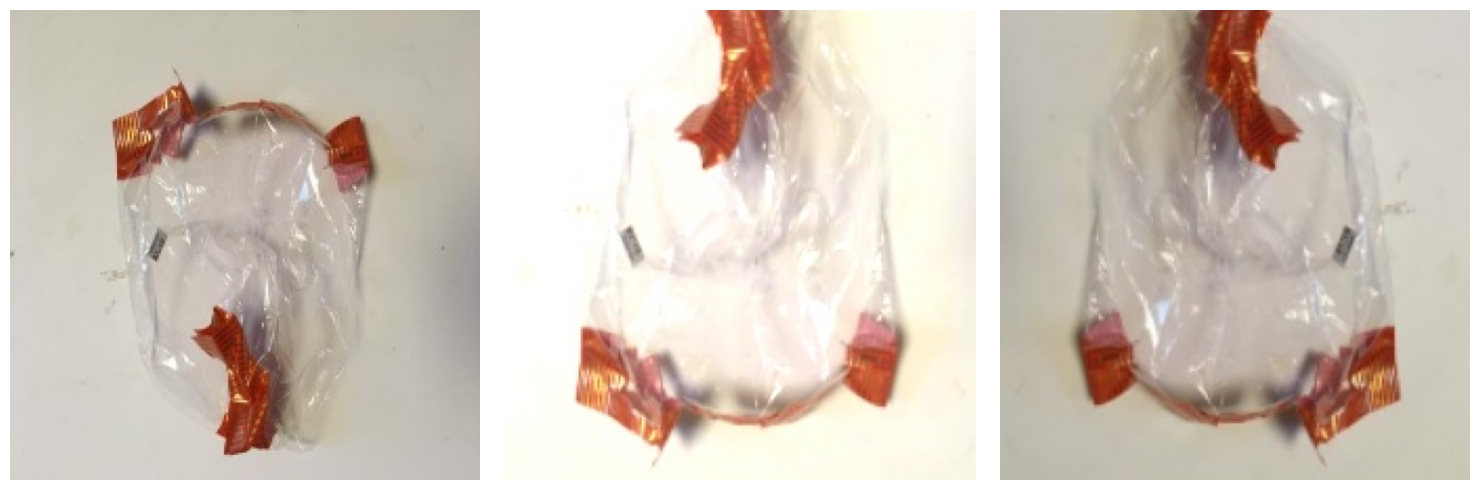

  d27a60e0-e229-4b1f-b053-c8bd78d86496.jpg
 2 agumented copies


In [40]:
## this code is just for showing the result of augumentation
import matplotlib.pyplot as plt
import cv2
import os
import random

PROCESSED_PATH = "/content/processed_dataset/train"
CLASS_NAME = "1_Paper"

folder_path = os.path.join(PROCESSED_PATH, CLASS_NAME)
if not os.path.exists(folder_path):
    found = [d for d in os.listdir(PROCESSED_PATH) if "cardboard" in d.lower()]
    if found:
        folder_path = os.path.join(PROCESSED_PATH, found[0])
        CLASS_NAME = found[0]

files = os.listdir(folder_path)


aug_files = [f for f in files if f.startswith("aug_")]
orig_files = [f for f in files if not f.startswith("aug_")]

if not orig_files:
    print("nothing")
else:
    random_orig = random.choice(orig_files)

    related_augs = [f for f in aug_files if f.endswith(random_orig)]

    plt.figure(figsize=(15, 5))

    img_path = os.path.join(folder_path, random_orig)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(related_augs) + 1, 1)
    plt.imshow(img)
    plt.axis('off')

    for i, aug_name in enumerate(related_augs):
        aug_path = os.path.join(folder_path, aug_name)
        aug_img = cv2.imread(aug_path)
        aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(related_augs) + 1, i + 2)
        plt.imshow(aug_img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"  {random_orig}")
    print(f" {len(related_augs)} agumented copies")


In [41]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [45]:
# Colab root
PROJECT_ROOT = "/content"

processed_dataset_dir = os.path.join(PROJECT_ROOT, "data", "processed_dataset")
train_dir = os.path.join(processed_dataset_dir, "train")
val_dir = os.path.join(processed_dataset_dir, "val")

classes = [
    "0_Glass",
    "1_Paper",
    "2_Cardboard",
    "3_Plastic",
    "4_Metal",
    "5_Trash"
]


In [46]:
print("Train directory exists:", os.path.exists(train_dir))
print("Available classes:", os.listdir(train_dir))


Train directory exists: True
Available classes: ['1_Paper', '3_Plastic', '0_Glass', '5_Trash', '2_Cardboard', '4_Metal']


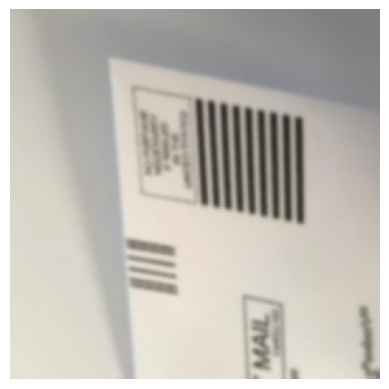

In [47]:
# Pick a sample image
sample_class = classes[1]  # Paper
sample_folder = os.path.join(train_dir, sample_class)
sample_files = [f for f in os.listdir(sample_folder) if f.endswith('.jpg')]

# Read one image
img_path = os.path.join(sample_folder, sample_files[0])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [48]:
def extract_hog_features(image, resize_dim=(128, 128)):
    """
    Extract HOG features from an image
    """
    # Resize to standard size
    img_resized = cv2.resize(image, resize_dim)

    # Convert to grayscale (HOG works on single channel)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

    # HOG extraction
    features, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )

    return features, hog_image


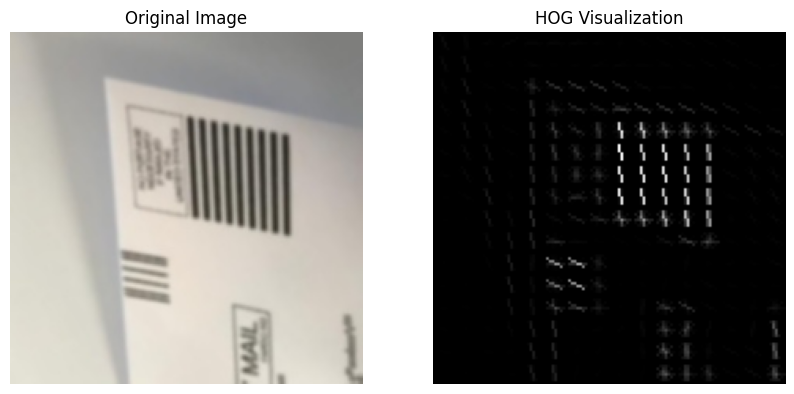

Feature vector length: 8100


In [49]:
features, hog_img = extract_hog_features(img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(hog_img, cmap='gray')
plt.title("HOG Visualization")
plt.axis('off')
plt.show()

print("Feature vector length:", len(features))

In [50]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    """
    Extract color histogram as feature vector
    """
    # Convert to HSV for better color separation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Compute 3D histogram
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180,0,256,0,256])

    # Normalize and flatten
    hist = cv2.normalize(hist, hist).flatten()

    return hist


In [51]:
hist_features = extract_color_histogram(img)
print("Color Histogram feature length:", len(hist_features))

Color Histogram feature length: 512


In [53]:
def extract_features(image, method='hog'):
    """
    image: input RGB image
    method: 'hog', 'color', or 'hog_color'
    returns: 1D feature vector
    """
    if method == 'hog':
        features, _ = extract_hog_features(image)
    elif method == 'color':
        features = extract_color_histogram(image)
    elif method == 'hog_color':
        hog_feat, _ = extract_hog_features(image)
        color_feat = extract_color_histogram(image)
        features = np.concatenate([hog_feat, color_feat])
    else:
        raise ValueError("Invalid method. Choose 'hog', 'color', or 'hog_color'")

    # Normalize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features.reshape(-1,1)).flatten()

    return features


In [54]:
X_train = []
y_train = []

for class_name in classes:
    folder = os.path.join(train_dir, class_name)
    for f in os.listdir(folder):
        if not f.lower().endswith('.jpg'): continue
        img_path = os.path.join(folder, f)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        feat = extract_features(img, method='color')  # choose method here
        X_train.append(feat)
        y_train.append(class_name)

print("Number of training samples:", len(X_train))
print("Feature vector size:", len(X_train[0]))


Number of training samples: 4449
Feature vector size: 512


In [55]:
#test correctness
sample_class = "1_Paper"
sample_folder = os.path.join(train_dir, sample_class)
sample_files = [f for f in os.listdir(sample_folder) if f.endswith('.jpg')]
img_path = os.path.join(sample_folder, sample_files[6])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

features = extract_features(img, method='color')  # or 'hog' / 'color'
print("Feature vector length:", len(features))
print("First 10 features:", features[:10])


Feature vector length: 512
First 10 features: [ 0.02150898 -0.11399761  0.03871616  8.461634    7.5431995   8.182017
 -0.21078803 -0.21078803 -0.16346826  0.11614851]


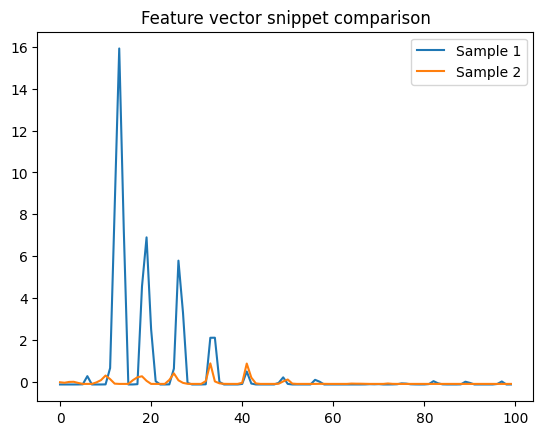

In [56]:
plt.plot(X_train[0][:100], label='Sample 1')
plt.plot(X_train[1][:100], label='Sample 2')
plt.legend()
plt.title("Feature vector snippet comparison")
plt.show()


In [57]:
#Quick classifier test
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train_arr = np.array(X_train)
y_train_arr = np.array(y_train)

X_tr, X_val, y_tr, y_val = train_test_split(X_train_arr, y_train_arr, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_tr, y_tr)
y_pred = knn.predict(X_val)

print("Quick test accuracy:", accuracy_score(y_val, y_pred))


Quick test accuracy: 0.7404494382022472
